In [1]:
from platform import python_version
print(python_version())

3.11.14


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from osgeo import gdal
gdal.UseExceptions()   
import numpy as np
import pylab as plt
import math
import sys
from matplotlib.patches import Circle
import ephem
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import get_sun, AltAz
from lunarsky import MoonLocation, LunarTopo 


In [3]:
# Loading the image and print metadata
dataset = gdal.Open(r"C:\Users\Abel Philip\Downloads\WAC_GLD100_E000N1800_064P.IMG", gdal.GA_ReadOnly )
# Check the dataset has been successfully open
# otherwise exit the script with an error message.
if dataset is None:
    print ("The dataset could not openned")
    sys.exit(-1)
# Print the driver information being used
print ('Driver: ', dataset.GetDriver().ShortName)
dataset.GetDriver().LongName
# Print the size of the image.
print ('Size is ', dataset.RasterXSize, 'x', dataset.RasterYSize)
'x', dataset.RasterCount
# Print the image projection.
print ('Projection is ', dataset.GetProjection())

# Get the geometric transformation
geotransform = dataset.GetGeoTransform()
# Check the whether the image has a geometric transformation
# if a transformation is found print associated information.
if not geotransform is None:
    print ('Origin = (',geotransform[0], ',',geotransform[3],')')
    print ('Pixel Size = (',geotransform[1], ',',geotransform[5]*-1,')')
    
image = dataset.GetRasterBand(1).ReadAsArray()
print(image.shape)


Driver:  PDS
Size is  23040 x 11520
Projection is  PROJCS["EQUIRECTANGULAR MOON",GEOGCS["GCS_MOON",DATUM["D_MOON",SPHEROID["MOON_localRadius",1737400,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Origin = ( -0.0 , 2729101.538173478 )
Pixel Size = ( 473.80235037733996 , 473.80235037733996 )
(11520, 23040)


Lunar pixels: (8960, 5440)


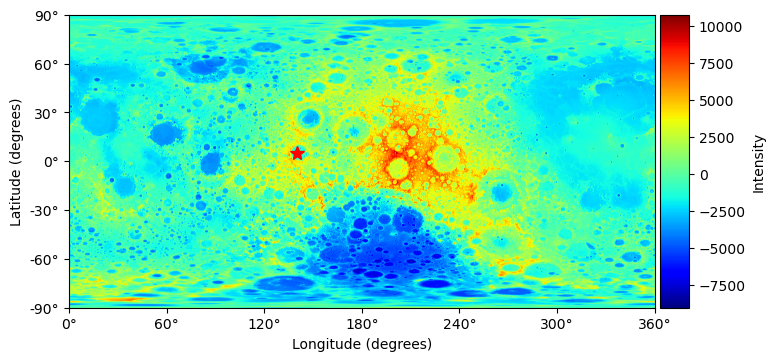

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

lunar_lon = 140
lunar_lat = 5

# convert lunar lon & lat into pixel coordinates
def coord2pix(lon, lat):
    row = (image.shape[0] / 2.) - (lat * image.shape[0] / 180.)
    col = lon * image.shape[1] / 360.
    return col, row

center_x, center_y = coord2pix(lunar_lon, lunar_lat)
center_x = int(np.round(center_x))
center_y = int(np.round(center_y))
print(f'Lunar pixels: {(center_x, center_y)}')

H, W = image.shape

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(image, cmap='jet', origin='upper')
ax.plot(center_x, center_y, 'r*', markersize=10)

# -----------------------
# X-axis: Longitude (0–360)
# -----------------------
lon_ticks_deg = np.arange(0, 361, 60)
lon_ticks_px = lon_ticks_deg * W / 360.0

ax.set_xticks(lon_ticks_px)
ax.set_xticklabels([f"{int(l)}°" for l in lon_ticks_deg])
ax.set_xlabel("Longitude (degrees)")

# -----------------------
# Y-axis: Latitude (-90–90)
# -----------------------
lat_ticks_deg = np.arange(-90, 91, 30)
lat_ticks_px = (H / 2.) - (lat_ticks_deg * H / 180.)

ax.set_yticks(lat_ticks_px)
ax.set_yticklabels([f"{int(l)}°" for l in lat_ticks_deg])
ax.set_ylabel("Latitude (degrees)")

# -----------------------
# Colorbar same height
# -----------------------
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="Intensity")

plt.show()


Equator: Terrain-corrected sunlight hours = 408.00 hours
Taken point: Terrain-corrected sunlight hours = 384.00 hours


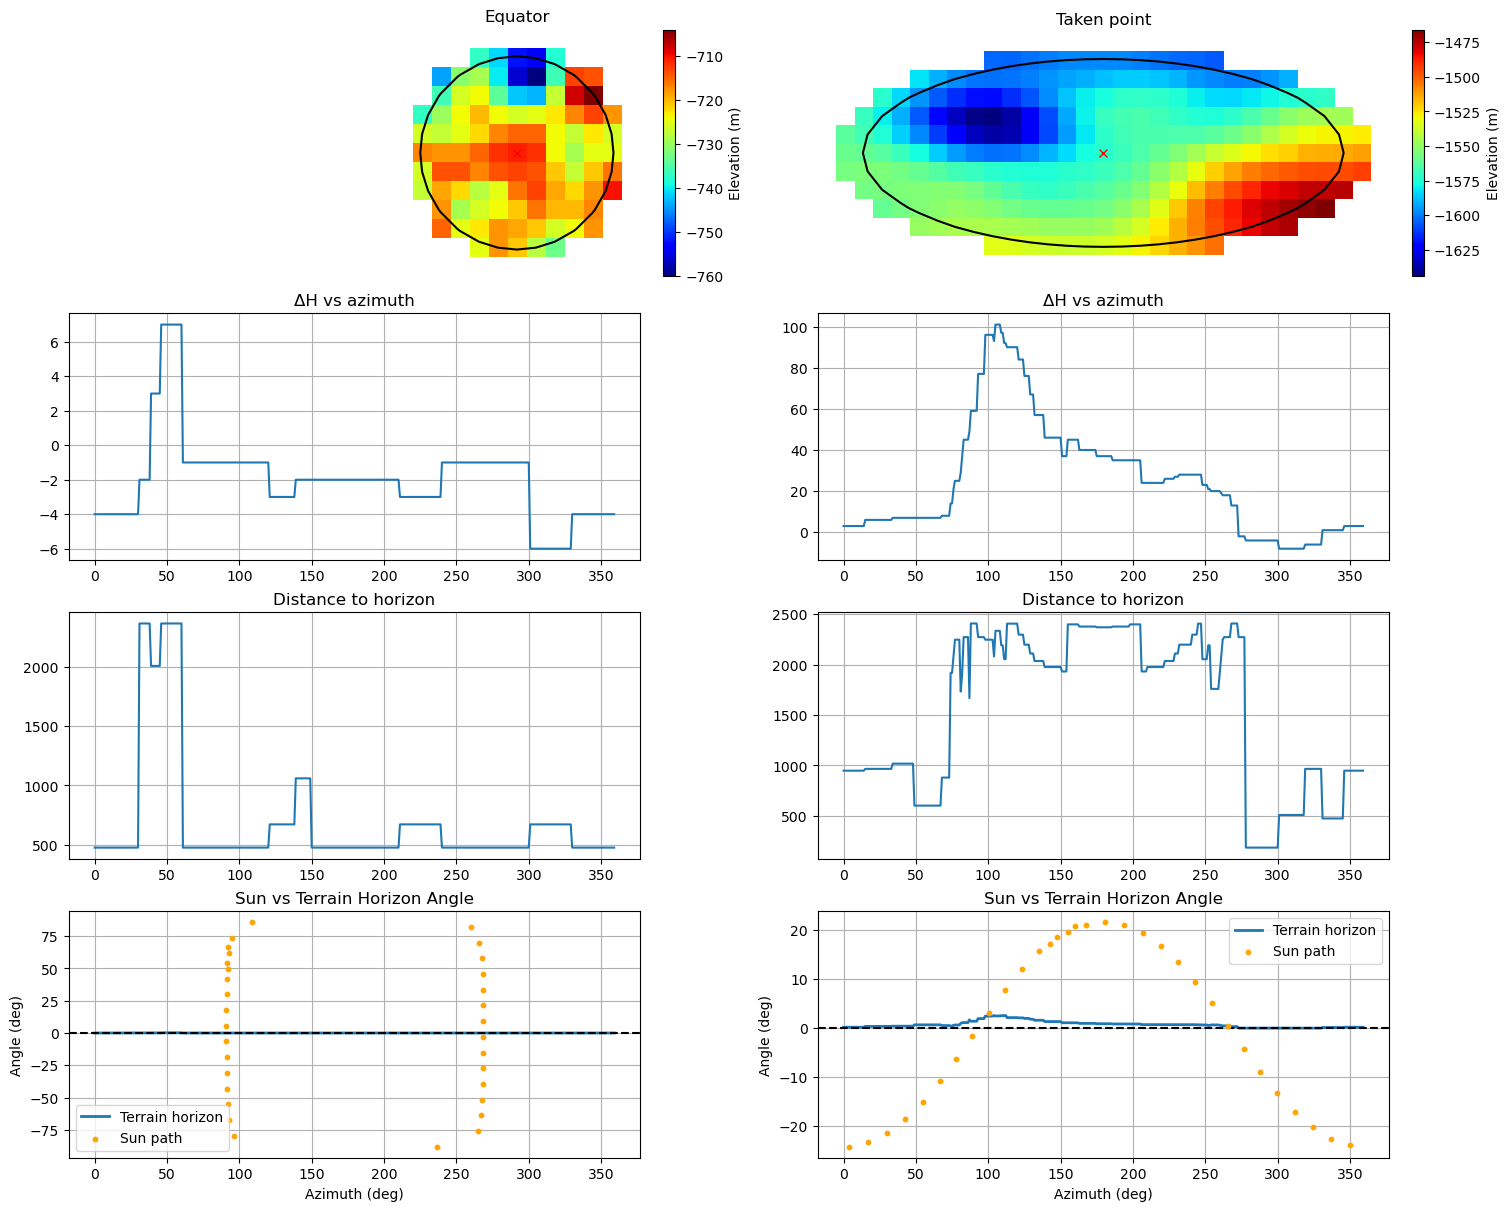

In [4]:
# ===============================
# CONSTANTS
# ===============================
MILES_2_METERS = 1609.344
RADIUS_METERS = 1.5 * MILES_2_METERS
MOON_RADIUS = 1737400.0  # meters

H, W = image.shape
deg_per_px_lon = 360.0 / W
deg_per_px_lat = 180.0 / H
meters_per_deg_lat = np.pi * MOON_RADIUS / 180.0

# ===============================
# COORD CONVERSION
# ===============================
def coord2pix(lon, lat):
    row = (H / 2.0) - (lat * H / 180.0)
    col = lon * W / 360.0
    return int(round(col)), int(round(row))

# ===============================
# EXTRACTION FUNCTION
# ===============================
def extract_radius_projection_aware(lon0, lat0):

    cx, cy = coord2pix(lon0, lat0)

    meters_per_deg_lon = meters_per_deg_lat * max(
        np.cos(np.deg2rad(lat0)), 0.05
    )

    px_x = meters_per_deg_lon * deg_per_px_lon
    px_y = meters_per_deg_lat * deg_per_px_lat
    half_diag = 0.5 * np.sqrt(px_x**2 + px_y**2)

    rx = int(np.ceil((RADIUS_METERS + half_diag) / px_x))
    ry = int(np.ceil((RADIUS_METERS + half_diag) / px_y))

    start_y = max(0, cy - ry)
    end_y   = min(H, cy + ry + 1)

    x_indices = (np.arange(cx - rx, cx + rx + 1) % W)

    stamp = image[start_y:end_y][:, x_indices]
    cx_l = rx
    cy_l = cy - start_y

    h, w = stamp.shape
    dist_map = np.zeros((h, w))
    mask = np.zeros((h, w), dtype=bool)

    for y in range(h):
        for x in range(w):
            dx = (x - cx_l) * px_x
            dy = (y - cy_l) * px_y
            d = np.sqrt(dx**2 + dy**2)
            dist_map[y, x] = d
            mask[y, x] = d <= (RADIUS_METERS + half_diag)

    extracted = np.where(mask, stamp, np.nan)
    return extracted, dist_map, cx_l, cy_l

# ===============================
# RADIAL HORIZON SCAN
# ===============================
def radial_horizon_scan(extracted, dist_map, cx, cy):

    center_elev = extracted[cy, cx]
    dist_to_max = np.full(360, np.nan)
    horizon_angle = np.full(360, np.nan)

    for az in range(360):
        theta = np.deg2rad(az)
        max_elev = -np.inf
        step = 1

        while True:
            x = int(round(cx + step * np.sin(theta)))
            y = int(round(cy - step * np.cos(theta)))

            if x < 0 or y < 0 or x >= extracted.shape[1] or y >= extracted.shape[0]:
                break

            d = dist_map[y, x]
            if d > RADIUS_METERS:
                break

            elev = extracted[y, x]
            if not np.isnan(elev) and elev > max_elev:
                max_elev = elev
                dist_to_max[az] = d

            step += 1

        if max_elev > -np.inf and dist_to_max[az] > 0:
            horizon_angle[az] = np.degrees(
                np.arctan((max_elev - center_elev) / dist_to_max[az])
            )

    delta_h = (np.tan(np.deg2rad(horizon_angle)) * dist_to_max)
    return delta_h, dist_to_max, horizon_angle

# ===============================
# SUN POSITION FUNCTION
# ===============================
def compute_sun_path(lon, lat, center_elev):

    moon_loc = MoonLocation(
        lon=lon * u.deg,
        lat=lat * u.deg,
        height=center_elev * u.m
    )

    start_time = datetime(2025, 1, 11)
    stop_time  = datetime(2025, 2, 11)
    increment  = timedelta(days=1)

    sun_alt, sun_az = [], []
    t = start_time

    while t <= stop_time:
        frame = LunarTopo(obstime=Time(t), location=moon_loc)
        sun = get_sun(Time(t)).transform_to(frame)
        sun_alt.append(sun.alt.deg)
        sun_az.append(sun.az.deg % 360)
        t += increment

    return np.array(sun_az), np.array(sun_alt)

# ===============================
# TEST CASES
# ===============================
cases = [
    (0, 0, "Equator"),
    (5, 67, "Taken point")
]
fig, axes = plt.subplots(4, 2, figsize=(15, 12), constrained_layout=True)

for col, (lon, lat, title) in enumerate(cases):

    extracted, dist_map, cx, cy = extract_radius_projection_aware(lon, lat)
    delta_h, dist_to_max, horizon_angle = radial_horizon_scan(
        extracted, dist_map, cx, cy
    )

    sun_az, sun_alt = compute_sun_path(lon, lat, extracted[cy, cx])

    horizon_angle = np.maximum(horizon_angle, 0.0)

    sun_visible = sun_alt > horizon_angle[np.floor(sun_az).astype(int) % 360]
    sunlight_hours = np.sum(sun_visible) * 24.0

    print(f"{title}: Terrain-corrected sunlight hours = {sunlight_hours:.2f} hours")

    # ---------------- Row 1: DEM
    ax = axes[0, col]
    im = ax.imshow(extracted, cmap="jet")
    ax.plot(cx, cy, "rx")
    ax.contour(dist_map, levels=[RADIUS_METERS], colors="k")
    ax.set_title(title)
    ax.axis("off")

    # Colorbar for each column
    cbar = fig.colorbar(
        im,
        ax=ax,
        orientation="vertical",
        fraction=0.046,
        pad=0.04
    )
    cbar.set_label("Elevation (m)")

    # ---------------- Row 2: ΔH
    axes[1, col].plot(delta_h)
    axes[1, col].set_title("ΔH vs azimuth")
    axes[1, col].grid(True)

    # ---------------- Row 3: Distance
    axes[2, col].plot(dist_to_max)
    axes[2, col].set_title("Distance to horizon")
    axes[2, col].grid(True)

    # ---------------- Row 4: Horizon + Sun
    ax = axes[3, col]
    ax.plot(horizon_angle, label="Terrain horizon", linewidth=2)
    ax.scatter(sun_az, sun_alt, s=10, c="orange", label="Sun path", zorder=3)
    ax.axhline(0, linestyle="--", color="k")
    ax.set_title("Sun vs Terrain Horizon Angle")
    ax.set_xlabel("Azimuth (deg)")
    ax.set_ylabel("Angle (deg)")
    ax.legend()
    ax.grid(True)

plt.show()



In [7]:
# ===============================
# BLOCK C: BATTERY CHARGING MODEL
# ===============================
#Use this part when required by changing the battery propertiesS

# --- Inputs (can be UI-controlled later) ---
sun_hours = sunlight_hours                # from terrain-corrected visibility
panel_power = 120.0                  # Watts (example: small lunar lander)
charge_eff = 0.85                    # 85% charging efficiency
battery_capacity = 2000.0            # Wh (example battery)
load_power = 80.0                    # Watts (average system load)
initial_soc = 0.30                   # 30% initial charge

# --- Energy generated by solar panels ---
energy_generated = sun_hours * panel_power * charge_eff  # Wh

# --- Initial battery energy ---
initial_energy = initial_soc * battery_capacity

# --- Final battery energy (capped at capacity) ---
final_energy = min(
    battery_capacity,
    initial_energy + energy_generated
)

final_soc = final_energy / battery_capacity

# --- Operational time from battery ---
operation_hours = final_energy / load_power

# --- Outputs ---
print("🔋 BATTERY PERFORMANCE SUMMARY")
print(f"Sunlight hours: {sun_hours:.2f} h")
print(f"Energy generated: {energy_generated:.2f} Wh")
print(f"Initial battery SOC: {initial_soc*100:.1f}%")
print(f"Final battery SOC: {final_soc*100:.1f}%")
print(f"Usable operation time: {operation_hours:.2f} hours")


🔋 BATTERY PERFORMANCE SUMMARY
Sunlight hours: 384.00 h
Energy generated: 39168.00 Wh
Initial battery SOC: 30.0%
Final battery SOC: 100.0%
Usable operation time: 25.00 hours
